In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import sunpy.map

from pathlib import Path
import os
import numpy as np
import datetime

import pdb
import importlib
import pickle, json
import locale
from sunpy.map import all_coordinates_from_map

locale.setlocale(locale.LC_ALL, "C");

In [2]:
import query_sunpy
importlib.reload(query_sunpy);

In [3]:
def cutout2box (_map, center_x, center_y , dx_km, shape):
    hmi_wcs = _map.wcs

    center_crd = crd = SkyCoord(center_x,center_y, unit=u.arcsec, frame=_map.coordinate_frame)\
                        .transform_to("heliographic_carrington")
    lon = center_crd.lon
    lat = center_crd.lat
    rad = center_crd.radius
    origin = SkyCoord(lon, lat, rad,
                      frame="heliographic_carrington",
                      observer="self",
                      obstime=_map.date)

    scale = np.arcsin(dx_km/origin.radius).to(u.deg)/u.pix
    scale = u.Quantity((scale, scale))
    box_header = sunpy.map.make_fitswcs_header(shape, origin,
                                               projection_code='CEA', scale=scale)

    outmap = _map.reproject_to(box_header, algorithm="adaptive", roundtrip_coords=False)

    return outmap

In [4]:
def hmi_b2ptr(map_field, map_inclination, map_azimuth):
    sz = map_field.data.shape
    ny, nx = sz

    field = map_field.data
    gamma = np.deg2rad(map_inclination.data)
    psi   = np.deg2rad(map_azimuth.data)
    
    b_xi  = -field * np.sin(gamma) * np.sin(psi)
    b_eta  = field * np.sin(gamma) * np.cos(psi)
    b_zeta = field * np.cos(gamma)

    foo = all_coordinates_from_map(map_field).transform_to("heliographic_stonyhurst")
    phi = foo.lon
    lambda_  = foo.lat

    b = np.deg2rad(map_field.fits_header["crlt_obs"])
    p = np.deg2rad(-map_field.fits_header["crota2"])
    
    phi, lambda_ = np.deg2rad(phi), np.deg2rad(lambda_)

    sinb, cosb = np.sin(b), np.cos(b)
    sinp, cosp = np.sin(p), np.cos(p)
    sinphi, cosphi = np.sin(phi), np.cos(phi)          # nx*ny
    sinlam, coslam = np.sin(lambda_), np.cos(lambda_)  # nx*ny

    k11 = coslam * (sinb * sinp * cosphi + cosp * sinphi) - sinlam * cosb * sinp
    k12 = - coslam * (sinb * cosp * cosphi - sinp * sinphi) + sinlam * cosb * cosp
    k13 = coslam * cosb * cosphi + sinlam * sinb
    k21 = sinlam * (sinb * sinp * cosphi + cosp * sinphi) + coslam * cosb * sinp
    k22 = - sinlam * (sinb * cosp * cosphi - sinp * sinphi) - coslam * cosb * cosp
    k23 = sinlam * cosb * cosphi - coslam * sinb
    k31 = - sinb * sinp * sinphi + cosp * cosphi
    k32 = sinb * cosp * sinphi + sinp * cosphi
    k33 = - cosb * sinphi

    bptr = np.zeros((3,nx, ny))

    bptr[0,:,:] = k31 * b_xi + k32 * b_eta + k33 * b_zeta
    bptr[1,:,:] = k21 * b_xi + k22 * b_eta + k23 * b_zeta
    bptr[2,:,:] = k11 * b_xi + k12 * b_eta + k13 * b_zeta

    header = map_field.fits_header
    map_bp = sunpy.map.Map(bptr[0,:,:], header)
    map_bt = sunpy.map.Map(bptr[1,:,:], header)
    map_br = sunpy.map.Map(bptr[2,:,:], header)
    
    
    return map_bp, map_bt, map_br

In [5]:
dl_path = "input_data/"

In [6]:
start_date = datetime.datetime.fromisoformat("2014-02-02T02:22:00.0")
end_date   = datetime.datetime.fromisoformat("2014-02-02T02:22:15.0")

In [7]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, print_only=True)

In [8]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, print_only=False)

In [9]:
#def gx_box_from_dir(cache_dir, model_dir, x, y, dx, dy, dz, res_km, top=0, cea=1, sfq=1, carrington=0):

x=-230
y=-110
dx=512
dy=256
dz=128

res_km=360.49

input_path = Path(os.path.expanduser(dl_path)).resolve()

if not input_path.exists():
    print("no input data")

field_path = list(input_path.glob("*.field.fits"))[0]
incli_path = list(input_path.glob("*.inclination.fits"))[0]
azimu_path = list(input_path.glob("*.azimuth.fits"))[0]
disam_path = list(input_path.glob("*.disambig.fits"))[0]
conti_path = list(input_path.glob("*.continuum.fits"))[0]
losma_path = list(input_path.glob("*.magnetogram.fits"))[0]
size_pix = f"[{dx}, {dy}, {dz}]"
centre = f"[{x}, {y}]"
wcs_rsun=6.96e8

In [10]:
#reading data from fits
map_field       = sunpy.map.Map(field_path)
map_inclination = sunpy.map.Map(incli_path)
map_azimuth     = sunpy.map.Map(azimu_path)
map_disambig    = sunpy.map.Map(disam_path)

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [11]:
#disambiguation
dis = map_disambig.data
map_azimuth.data[:,:] = map_azimuth.data + dis*180.

map_bp, map_bt, map_br = hmi_b2ptr(map_field, map_inclination, map_azimuth)
box_bx = cutout2box(map_bp, x, y, res_km * u.km, [dy, dx])
box_by = cutout2box(map_bt, x, y, res_km * u.km, [dy, dx])
box_bz = cutout2box(map_br, x, y, res_km * u.km, [dy, dx])
box_by.data[:,:] *= -1

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [12]:
earth_observer = SkyCoord(0*u.deg, 0*u.deg, 0*u.km, frame=frames.GeocentricEarthEquatorial, observer="earth", obstime=box_bx.date)

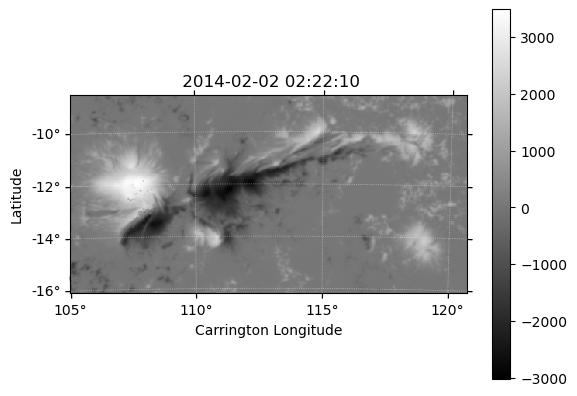

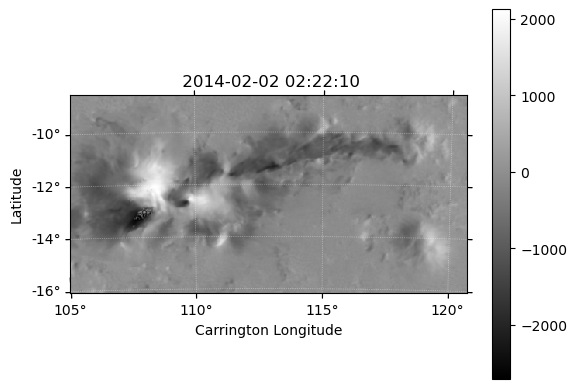

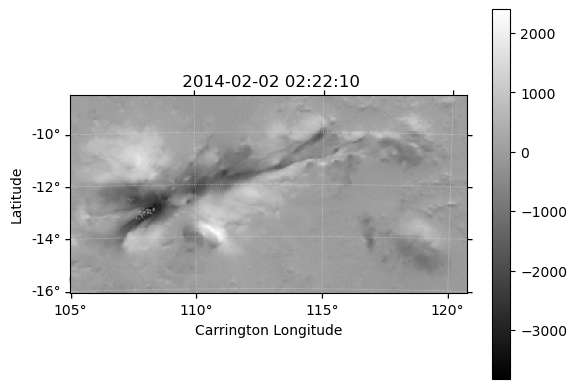

In [13]:
box_bz.peek()
box_bx.peek()
box_by.peek()

In [14]:
from lff import mf_lfff
import sys

In [15]:
maglib_lff = mf_lfff()
maglib_lff.set_field(box_bz.data)

In [16]:
res1 = maglib_lff.lfff_cube(dz)

In [17]:
bx_lff, by_lff, bz_lff = res1["bx"], res1["by"], res1["bz"]

In [18]:
bx_lff.shape

(256, 512, 128)

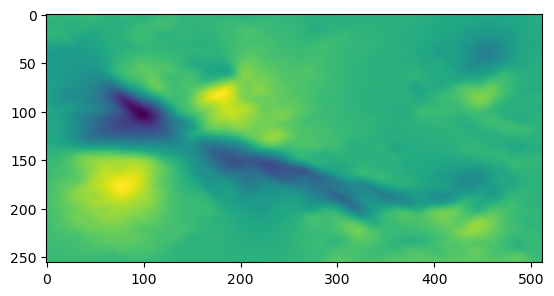

In [19]:
plt.imshow(bx_lff[:, :, 5])

In [20]:
wrapper_path = "./nlfff/python/ASMagLibPy/"
nlfff_libpath = (Path(wrapper_path) / '../../binaries/WWNLFFFReconstruction.so').resolve()
radio_libpath = "./rendergrff/binaries/RenderGRFF.so"

os.environ['OMP_NUM_THREADS']='16' # number of parallel threads

sys.path.append(wrapper_path)
from MagFieldWrapper import MagFieldWrapper

In [21]:
maglib = MagFieldWrapper(nlfff_libpath)

dr = (map_field.rsun_obs / map_field.rsun_meters * res_km).value
maglib.load_cube_vars(bx_lff, by_lff, bz_lff, dr)

box = maglib.NLFFF()
energy_new = maglib.energy
print('NLFFF energy:     ' + str(energy_new) + ' erg')

print("Calculating field lines")
lines = maglib.lines(seeds = None)

NLFFF energy:     1.755413462782145 erg
Calculating field lines


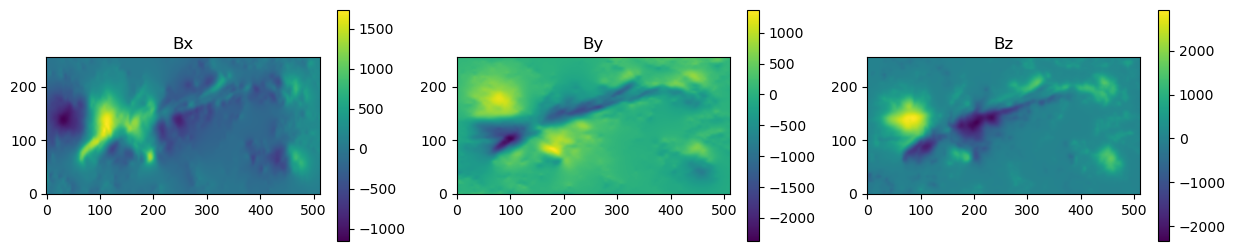

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
axes = (ax1, ax2, ax3)

for a, arr, ttl in zip(axes, (box["bx"], box["by"], box["bz"]), ("Bx", "By", "Bz")):
    im = a.imshow(arr[:, :, 3], origin="lower")
    plt.colorbar(im, ax=a)
    a.set_title(ttl)
fig.show()